In [1]:
!pip install qiskit numpy qiskit-aer scipy matplotlib git+https://github.com/quantum-programming/pygridsynth.git pylatexenc

  Cloning https://github.com/quantum-programming/pygridsynth.git to /tmp/pip-req-build-yed1508h
  Running command git clone --filter=blob:none --quiet https://github.com/quantum-programming/pygridsynth.git /tmp/pip-req-build-yed1508h
  Resolved https://github.com/quantum-programming/pygridsynth.git to commit 5868c650ce819227adcd80eaa8d8e065f4001022
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# 期待値の推定

ここでは簡単に 1 量子ビットの量子回路で Z 演算子の期待値を推定してみます。

In [2]:
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
import numpy as np

qc = QuantumCircuit(1)
qc.rx(np.pi/3, 0)
qc.save_statevector()
qc.measure_all()
simulator = AerSimulator(method='statevector')
result = simulator.run(qc, shots=1000).result()
vec = np.asarray(result.get_statevector())
print(vec)
counts = result.get_counts()
print(counts)
print("exact:", vec.conj() @ np.diag([1, -1]) @ vec)
print("estimated:", (counts.get('0', 0) - counts.get('1', 0)) / 1000)

[0.8660254+0.j  0.       -0.5j]
{'1': 270, '0': 730}
exact: (0.5000000000000002+0j)
estimated: 0.46


# 基本的なゲート間の変換をみる

行列成分を1行で簡単にみれるように関数定義しておきます。

In [3]:
from qiskit_aer import AerSimulator
import numpy as np

def get_unitary_from_circuit(qc):
    simulator = AerSimulator(method='unitary')
    result = simulator.run(qc).result()
    return result.get_unitary(qc).data

import matplotlib.pyplot as plt

def display_complex_matrix(matrix, title=None):
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))  # Set the figure size to be larger and create two subplots

    # Plot the angle of the matrix elements with a fixed color scale
    cax1 = ax[0].matshow(np.angle(matrix), cmap='hsv', vmin=-np.pi, vmax=np.pi)
    fig.colorbar(cax1, ax=ax[0])
    ax[0].set_title('Angle')

    # Plot the absolute value of the matrix elements
    cax2 = ax[1].matshow(np.abs(matrix), cmap='viridis', vmin=0, vmax=1)
    fig.colorbar(cax2, ax=ax[1])
    ax[1].set_title('Absolute Value')

    if title is not None:
        fig.suptitle(title)
    plt.show()

$\mathrm{CNOT} = (I\otimes H) \mathrm{CZ} (I\otimes H)$

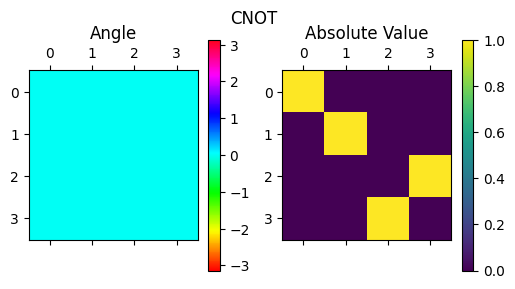

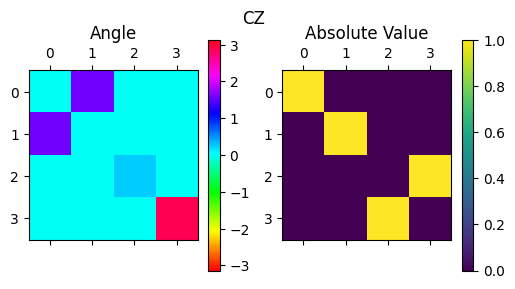

In [4]:
from qiskit import QuantumCircuit

# Create a quantum circuit
cnot = QuantumCircuit(2)
cnot.cx(1, 0)
cnot.save_unitary()

# cz
cnot2 = QuantumCircuit(2)
cnot2.h(0)
cnot2.cz(0, 1)
cnot2.h(0)
cnot2.save_unitary()

# Use the AerSimulator to get the unitary matrix

display_complex_matrix(get_unitary_from_circuit(cnot), title="CNOT")
display_complex_matrix(get_unitary_from_circuit(cnot2), title="CZ")

SWAP <-> CNOT

CY <-> CNOT

Rz <-> Rx

# CNOT + 1量子ビットゲートの万能性

色々理屈をこねて証明することはできるが、qiskit には Isometry という名前で任意のユニタリを実現できる関数が実装されているのでそれを使うと万能性を実感できる。原論文は https://arxiv.org/abs/1501.06911 。Qiskit の U3 gate は任意の1量子ビットユニタリに対応する。

0.17734088262078984


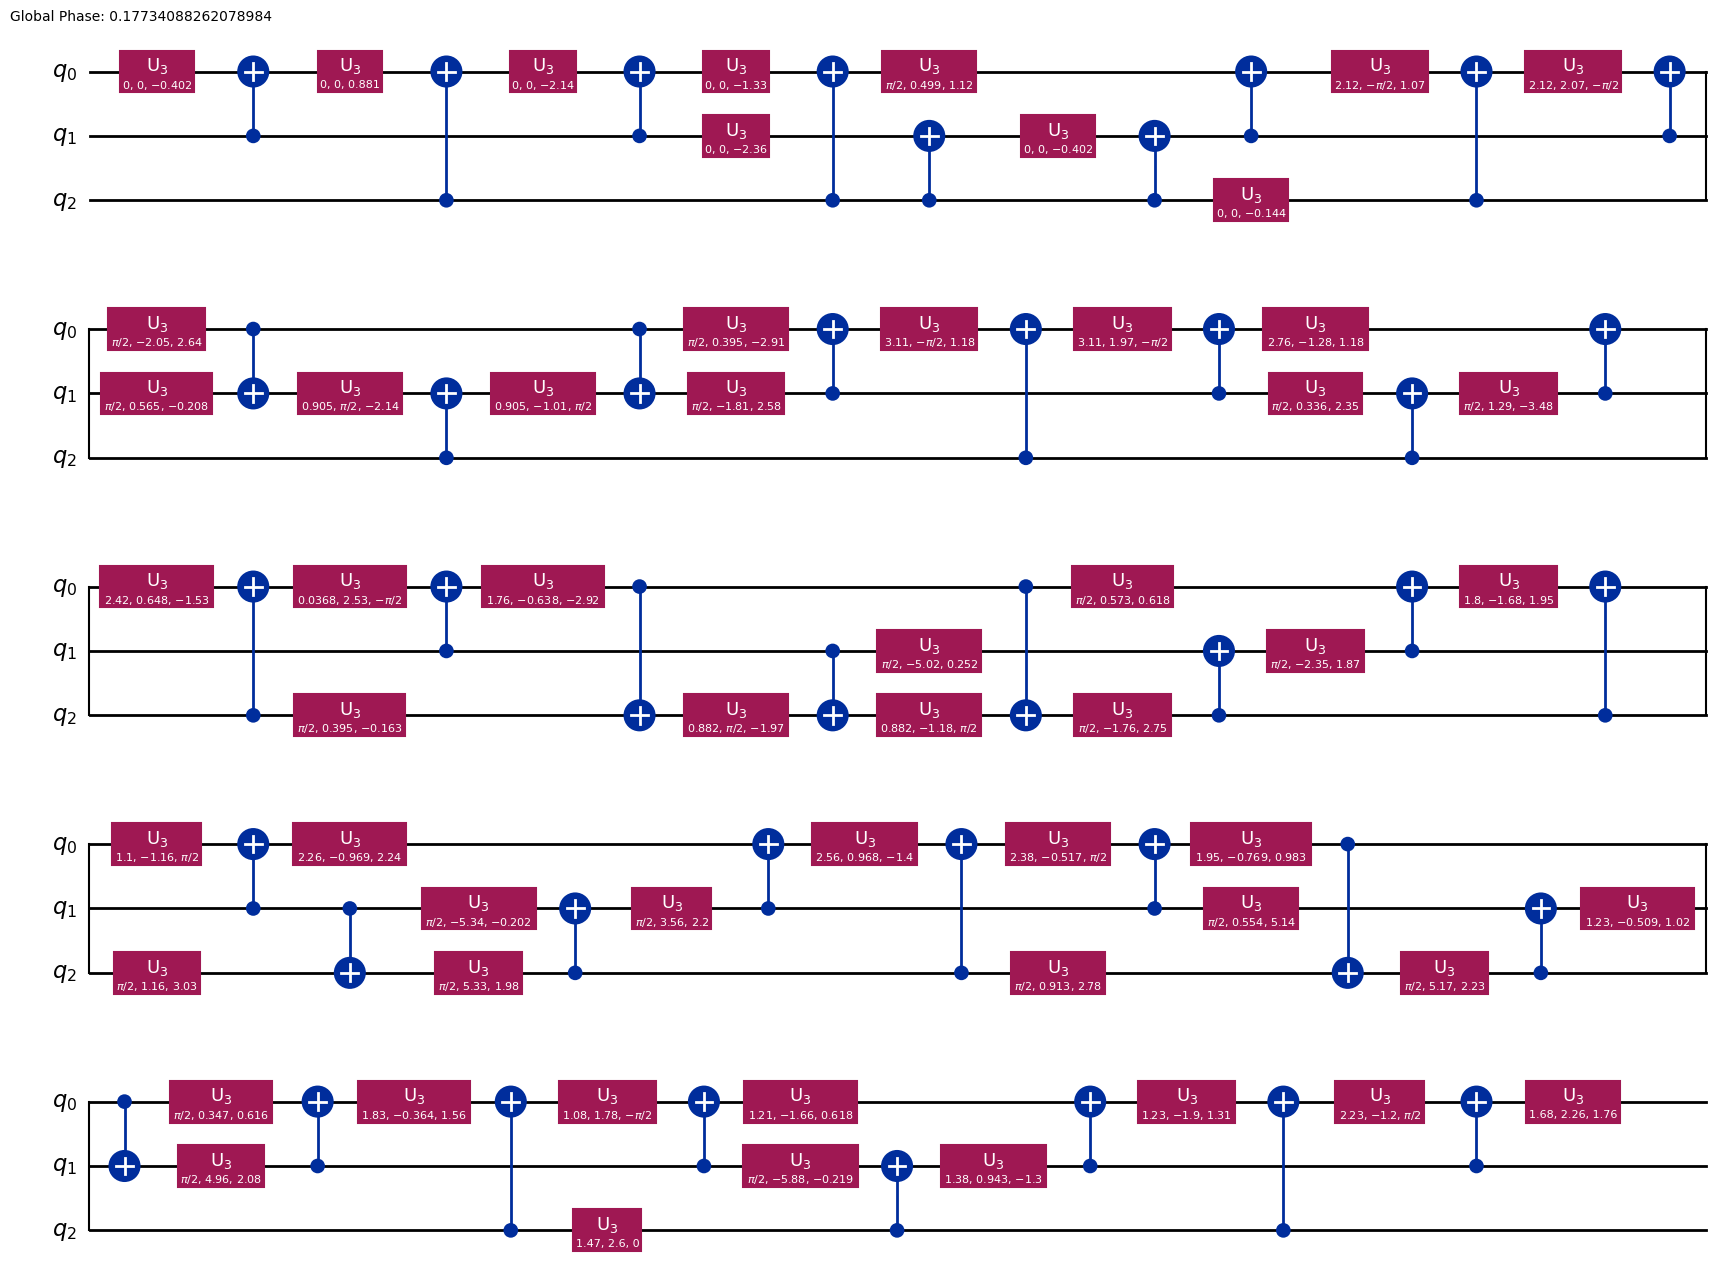

In [5]:
from scipy.stats import unitary_group
from qiskit.circuit.library.generalized_gates import Isometry
from qiskit import transpile
from qiskit import QuantumCircuit
random_unitary = unitary_group.rvs(2**3)
qc = QuantumCircuit(3)
qc.append(Isometry(random_unitary, 0, 0), qc.qubits)
qc_transpiled = transpile(qc, basis_gates=['u3', 'cx', 'cz'])
print(qc_transpiled.global_phase)
qc_transpiled.draw("mpl")

実際に回路を実行してみると、以下のようにしっかり実現できていることが確認できる。

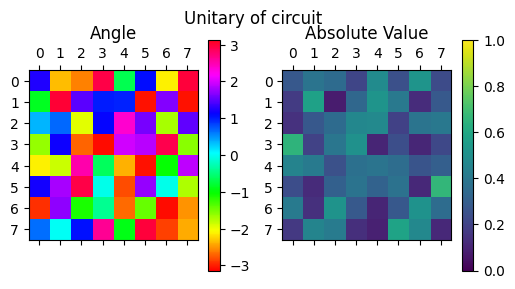

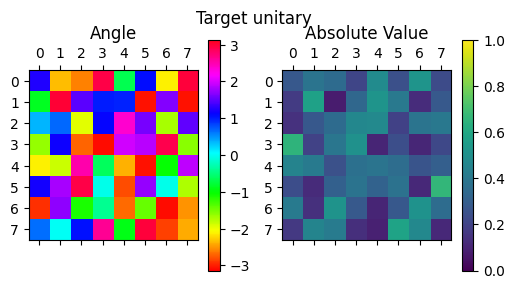

In [6]:
qc_transpiled.save_unitary()
display_complex_matrix(get_unitary_from_circuit(qc_transpiled), title="Unitary of circuit")
display_complex_matrix(random_unitary, title="Target unitary")

# 1 量子ビットゲートを H, T, S だけで表現する

FTQC では誤り耐性の代償として、離散的なゲートセットのみを実行できる。利用する誤り訂正符号によるが、例えば表面符号では１量子ビットゲートとして利用できるのは H, T, S のみとすることが多い。このような制約下で任意の１量子ビットユニタリを表現する方法を考える。

と言っても先人の知恵を借りるだけでよい。ここでは https://github.com/quantum-programming/pygridsynth を利用する。`pip install pygridsynth` でインストールできる。原論文は https://arxiv.org/abs/1403.2975 であり
彼らは Haskell 実装のみを提供しているが、Python に移植したものが pygridsynth である。pygridsynth は体感 1/2 くらいの確率でうまく行かない。本家はそんなことはない。

In [ ]:
import pygridsynth
from qiskit.circuit.library import HGate
# generate string consisting of {T,H,S,W} which corresponds to Rz(theta) with precision epsilon
# W corresponds to global phase shift of pi/4
theta = np.random.rand()
gates = pygridsynth.gridsynth_gates(theta, epsilon=1e-5)
print(gates)
qc = QuantumCircuit(1)
for gate in gates[::-1]:
    if gate == 'T':
        qc.t(0)
    elif gate == 'H':
        qc.h(0)
    elif gate == 'S':
        qc.s(0)
    elif gate == 'W':
        qc.global_phase += np.pi/4
qc.save_unitary()
unitary = get_unitary_from_circuit(qc)
print("error: ", np.linalg.norm(get_unitary_from_circuit(qc) - RZGate(theta).to_matrix()))
display_complex_matrix(get_unitary_from_circuit(qc), title="Unitary of circuit")
from qiskit.circuit.library import RZGate
display_complex_matrix(RZGate(theta).to_matrix(), title="Exact Rz")

## 2量子ビットパウリによる回転ゲート

$exp(i\theta ZZ)$ のような 2 量子ビットのパウリ演算子による回転ゲートは、CNOT と 1 量子ビットゲートを組み合わせることで実現できることを見ます：

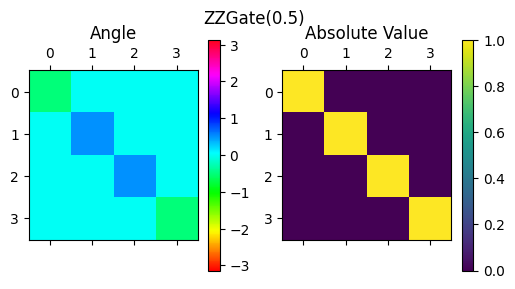

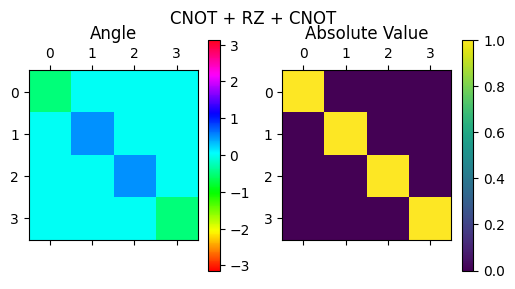

In [10]:
# exp(-i\theta ZZ) gate
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
qc = QuantumCircuit(2)
p = SparsePauliOp('ZZ', 1.0)
qc.append(PauliEvolutionGate(p, time=0.5), [0, 1])
qc = transpile(qc, basis_gates=['u3', 'cx', 'cz'])
qc.save_unitary()
display_complex_matrix(get_unitary_from_circuit(qc), title="ZZGate(0.5)")

# exp ZZ gate can be composed of CNOT and CZ gates
qc = QuantumCircuit(2)
qc.cx(0, 1)
qc.rz(1.0, 1)
qc.cx(0, 1)
qc = transpile(qc, basis_gates=['u3', 'cx', 'cz'])
qc.save_unitary()
display_complex_matrix(get_unitary_from_circuit(qc), title="CNOT + RZ + CNOT")

$exp(i\theta XX), exp(i\theta YY)$ も同様に実現できます。やってみましょう。